# EMOTION ANALYSIS

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/03-emotion-analysis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/03-emotion-analysis.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/03-emotion-analysis.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA Server
We are reusing the start server notebook for launching the EVA server

In [1]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File ‘00-start-eva-server.ipynb’ already there; not retrieving.




[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


nohup eva_server >> eva.log 2>&1 &
('03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF FastRCNNObjectDetector already exists, nothing added.\n', '03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF ArrayCount already exists, nothing added.\n', '03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF Timestamp already exists, nothing added.\n')
('03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF Crop already exists, nothing added.\n', '03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF YoloV5 already exists, nothing added.\n', '03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF Open already exists, nothing added.\n')
('03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF Similarity already exists, nothing added.\n', '03-18-2023 23:59:49 WARNING[create_


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


### Video Files
getting some video files to test

In [2]:
# A video of a happy person
!wget -nc https://www.dropbox.com/s/gzfhwmib7u804zy/defhappy.mp4?raw=1 -O defhappy.mp4

# Adding Emotion detection
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/emotion_detector.py

# Adding Face Detector
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/face_detector.py

zsh:1: no matches found: https://www.dropbox.com/s/gzfhwmib7u804zy/defhappy.mp4?raw=1


File ‘emotion_detector.py’ already there; not retrieving.



File ‘face_detector.py’ already there; not retrieving.



### Adding the video file to EVADB for analysis

In [3]:
cursor.execute('DROP TABLE HAPPY')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD VIDEO "defhappy.mp4" INTO HAPPY')
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                    0
0  Table Successfully dropped: HAPPY
@query_time: 0.07021994329988956


@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded VIDEO: 1
@query_time: 0.10749324597418308


### Visualize Video

In [4]:
from IPython.display import Video
Video("defhappy.mp4", height=450, width=800, embed=True)

### Create an user-defined function(UDF) for analyzing the frames

In [5]:
cursor.execute("""CREATE UDF IF NOT EXISTS EmotionDetector 
        INPUT (frame NDARRAY UINT8(3, ANYDIM, ANYDIM)) 
        OUTPUT (labels NDARRAY STR(ANYDIM), scores NDARRAY FLOAT32(ANYDIM)) 
        TYPE  Classification IMPL 'emotion_detector.py';
        """)
response = cursor.fetch_all()
print(response)
cursor.execute("""CREATE UDF IF NOT EXISTS FaceDetector
                  INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
                  OUTPUT (bboxes NDARRAY FLOAT32(ANYDIM, 4),
                          scores NDARRAY FLOAT32(ANYDIM))
                  TYPE  FaceDetection
                  IMPL  'face_detector.py';
        """)
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                                     0
0  UDF EmotionDetector already exists, nothing added.
@query_time: 0.01538027822971344
@status: ResponseStatus.SUCCESS
@batch: 
                                                  0
0  UDF FaceDetector already exists, nothing added.
@query_time: 0.01039818674325943


### Run the Face Detection UDF on video 

In [6]:
cursor.execute("""SELECT id, FaceDetector(data)
                  FROM HAPPY WHERE id<10""")
response = cursor.fetch_all()
response.as_df()

happy.id                                facedetector.bboxes  \
0         0  [[502.09558, 94.7437, 762.74475, 435.03775], [...   
1         1      [[501.1374, 96.631165, 763.36743, 435.53503]]   
2         2         [[504.3001, 97.2374, 766.1764, 437.54565]]   
3         3        [[498.8839, 90.225586, 776.1115, 446.6857]]   
4         4      [[496.76352, 99.69525, 767.28284, 444.63013]]   
5         5  [[499.95078, 87.45927, 777.3138, 448.34247], [...   
6         6        [[500.9568, 89.65959, 778.18036, 449.9886]]   
7         7        [[501.0684, 89.68475, 781.5416, 452.76913]]   
8         8        [[503.9379, 90.71915, 783.1767, 450.01434]]   
9         9        [[508.16498, 87.87092, 786.719, 447.48535]]   

        facedetector.scores  
0  [0.99990165, 0.79820246]  
1                [0.999918]  
2               [0.9999138]  
3              [0.99996686]  
4               [0.9999982]  
5    [0.9999136, 0.8369736]  
6               [0.9999131]  
7               [0.9999124]  
8              [0.99994683]  
9                [0.999949]

### Run the Emotion Detection UDF on the outputs of the Face Detection UDF

In [7]:
cursor.execute("""SELECT id, bbox, EmotionDetector(Crop(data, bbox)) 
                  FROM HAPPY JOIN LATERAL  UNNEST(FaceDetector(data)) AS Face(bbox, conf)  
                  WHERE id < 15;""")
response = cursor.fetch_all()
response.as_df()

happy.id                                    Face.bbox  \
0          0  [502.09558, 94.743706, 762.7447, 435.03775]   
1          0   [238.40054, 296.866, 325.83606, 398.96976]   
2          1   [501.1374, 96.63116, 763.36743, 435.53503]   
3          2    [504.3001, 97.23739, 766.1764, 437.54565]   
4          3     [498.8839, 90.2256, 776.1115, 446.68573]   
5          4    [496.7635, 99.695244, 767.2827, 444.6301]   
6          5   [499.95078, 87.45927, 777.3137, 448.34247]   
7          5    [236.3095, 305.2306, 324.2936, 407.17636]   
8          6   [500.95682, 89.6596, 778.18036, 449.98856]   
9          7  [501.06842, 89.684746, 781.5416, 452.76913]   
10         8   [503.93787, 90.71912, 783.1767, 450.01437]   
11         9   [508.16495, 87.870926, 786.719, 447.48535]   
12        10   [505.75592, 86.39983, 788.2796, 452.00793]   
13        10   [235.71637, 309.3378, 322.3492, 411.71494]   
14        11    [514.1758, 85.36888, 790.00885, 454.5724]   
15        12   [514.0587, 86.52281, 790.05176, 454.26816]   
16        13   [515.3848, 87.17474, 790.03156, 454.53625]   
17        14    [516.70447, 86.40688, 792.727, 455.34448]   

   emotiondetector.labels  emotiondetector.scores  
0                   happy                0.999642  
1                 neutral                0.780949  
2                   happy                0.999644  
3                   happy                0.999668  
4                   happy                0.999654  
5                   happy                0.999649  
6                   happy                0.999710  
7                 neutral                0.760779  
8                   happy                0.999671  
9                   happy                0.999671  
10                  happy                0.999689  
11                  happy                0.999691  
12                  happy                0.999729  
13                neutral                0.407872  
14                  happy                0.999745  
15                  happy                0.999729  
16                  happy                0.999718  
17                  happy                0.999739

In [8]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        df = detections
        df = df[['Face.bbox', 'emotiondetector.labels', 'emotiondetector.scores']][df.index == frame_id]
        if df.size:
            
            x1, y1, x2, y2 = df['Face.bbox'].values[0]
            label = df['emotiondetector.labels'].values[0]
            score = df['emotiondetector.scores'].values[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            # object bbox
            frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
            # object label
            cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
            # object score
            cv2.putText(frame, str(round(score, 5)), (x1+120, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
            # frame label
            cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
        
            video.write(frame)
            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(frame)
                plt.show()
        
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

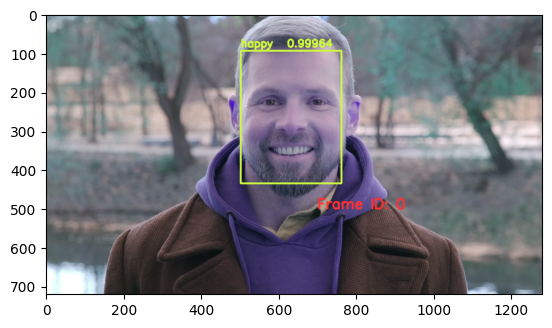

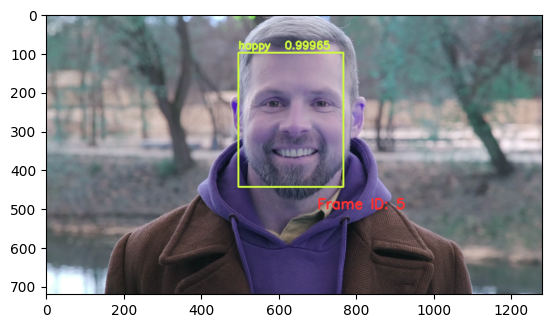

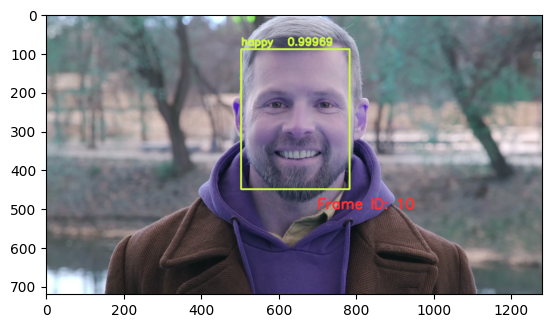

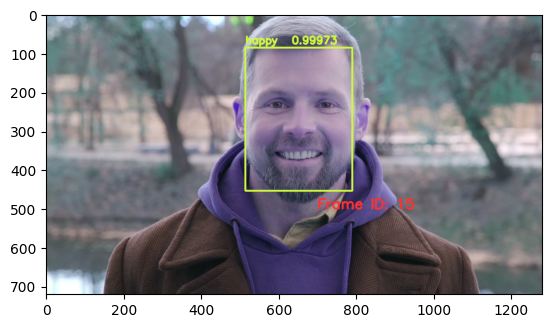

In [9]:
from ipywidgets import Video, Image
input_path = 'defhappy.mp4'
output_path = 'video.mp4'

dataframe = response.as_df()
annotate_video(dataframe, input_path, output_path)